In [1]:
import settings as settings
from src.data import dataexplore as dtexp
from fbprophet import Prophet
from src.data import datacleaner as dtclean
from src.visualization import data_visualization as dtview
from src.data import make_dataset as make_ds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import warnings
import seaborn as sns

plt.style.use('ggplot')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

warnings.filterwarnings('ignore')

path = str(settings.settings.get('PATH'))[:-5]
csvpath = path + str(settings.settings.get('CSVPATH'))[-15:]
imgpath = path + str(settings.settings.get('IMGPATH'))[-4:]

In [ ]:
df_h_cli = make_ds.get_dataset_store(store='63', is_client=True)
df_h_sales = make_ds.get_dataset_store(store='63', is_client=False)

# Client dataframe analysis

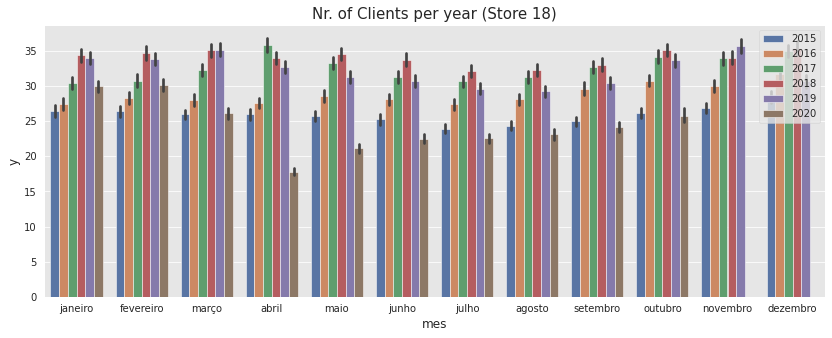

In [3]:
df_cli_new=dtexp.extract_date_features(df_h_cli)
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="mes", y="y",hue = 'ano',data=df_cli_new)
a.set_title("Nr. of Clients per year (Store 18)",fontsize=15)
plt.legend(loc='upper right')
plt.show()

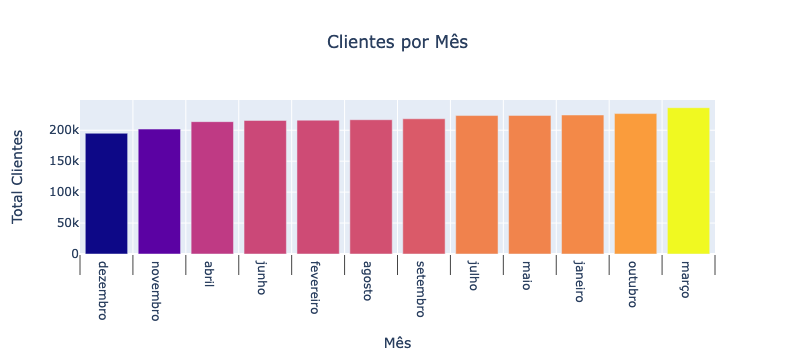

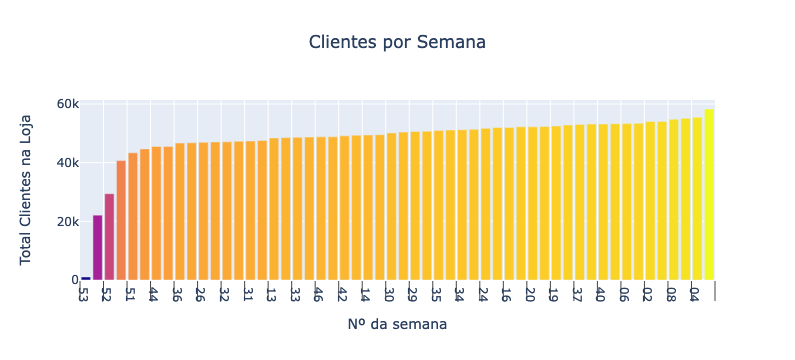

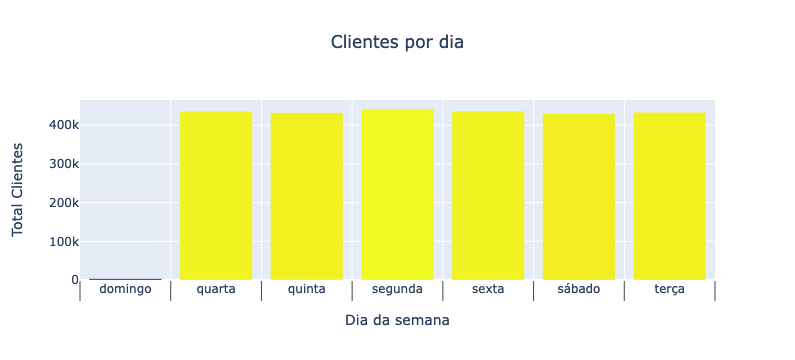

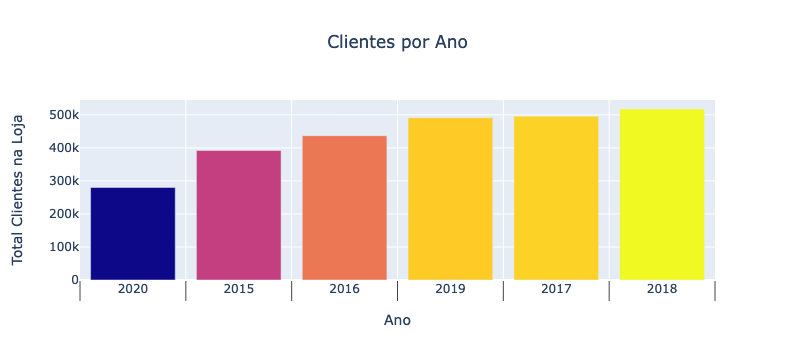

In [4]:
ano_agregado ,mes_agregado ,semana_agregado, dia_agregado = dtexp.analyze_dataframe(df_h_cli)
iplot(dtview.plot_dados_agregados_semana_mes(mes_agregado,tipo_agregacao='m',xaxes_title='Mês',yaxis_title='Total Clientes',
                                      title='Clientes por Mês'))
iplot(dtview.plot_dados_agregados_semana_mes(semana_agregado,tipo_agregacao='s',xaxes_title='Nº da semana',yaxis_title='Total Clientes na Loja',
                                      title='Clientes por Semana'))

iplot(dtview.plot_dados_agregados_semana_mes(dia_agregado,tipo_agregacao='d',xaxes_title='Dia da semana',yaxis_title='Total Clientes',
                                      title='Clientes por dia'))

iplot(dtview.plot_dados_agregados_semana_mes(ano_agregado,tipo_agregacao='a',xaxes_title='Ano',yaxis_title='Total Clientes na Loja',
                                      title='Clientes por Ano'))


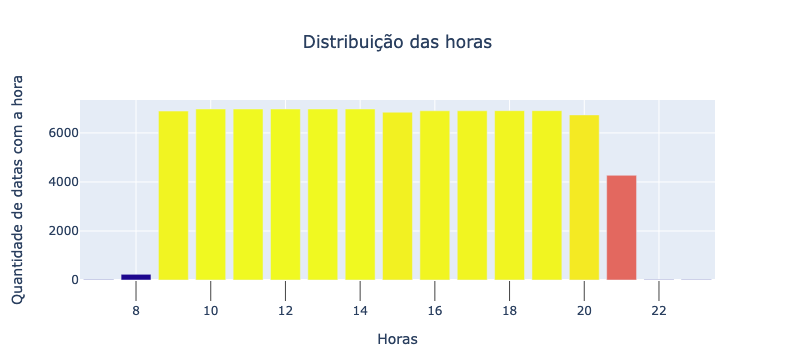

In [5]:
make_ds.save_processed_dataset(df_h_cli, filename='63_distribuicao_horas_por_dia.csv')
pd.DataFrame(df_h_cli.groupby(df_h_cli['ds'].dt.hour)["ds"].count()).to_csv(csvpath + '/'+'63_distribuicao_horas_por_dia.csv')
df_distrib_horas= make_ds.load_processed_dataset('63_distribuicao_horas_por_dia.csv')
df_distrib_horas.columns
hora=df_distrib_horas['ds'].tolist()
qtd_units=df_distrib_horas['ds.1'].tolist()
x_values=hora
y_values=qtd_units
title='Distribuição das horas'
xaxes_title='Horas'
yaxis_title='Quantidade de datas com a hora'
dtview.plot_results(x_values,y_values,title=title,xaxes_title=xaxes_title,yaxis_title=yaxis_title)

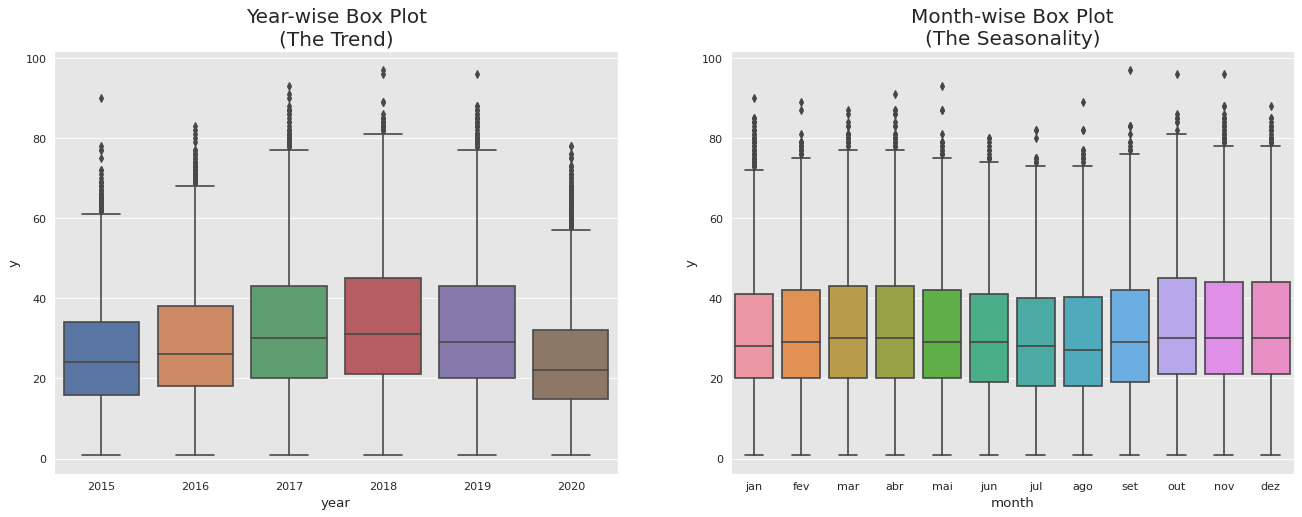

In [6]:
dtview.plot_bp_trend_seasonality(df_h_cli)


In [7]:
dtview.print_dataframe_core_info(df_h_cli)
print('Dataframe information: {}'.format(df_h_cli.info()))
df_h_cli.describe()

+-----------------------+---------------------+--------------------+
| Sales Dataframe Start | Sales Dataframe End | Data Period Range  |
+-----------------------+---------------------+--------------------+
|  2015-01-02 10:00:00  | 2020-10-17 21:15:00 | 2115 days 11:15:00 |
+-----------------------+---------------------+--------------------+
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87517 entries, 4063241 to 4150757
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   87517 non-null  int64         
 1   store   87517 non-null  int64         
 2   ds      87517 non-null  datetime64[ns]
 3   sales   87517 non-null  int64         
 4   y       87517 non-null  float64       
 5   year    87517 non-null  int64         
 6   month   87517 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 7.4+ MB
Dataframe information: None


index    store         sales             y          year
count  8.751700e+04  87517.0  87517.000000  87517.000000  87517.000000
mean   4.106999e+06     63.0    174.309300     29.869225   2017.396597
std    2.526413e+04      0.0    289.415496     15.382164      1.662388
min    4.063241e+06     63.0  -4542.000000      1.000000   2015.000000
25%    4.085120e+06     63.0     85.000000     18.000000   2016.000000
50%    4.106999e+06     63.0    136.000000     27.000000   2017.000000
75%    4.128878e+06     63.0    201.000000     40.000000   2019.000000
max    4.150757e+06     63.0  10372.000000     97.000000   2020.000000

# Split into train and test dataframe


# Finding dataframe data points (It is how prophet defines history_size)

In [5]:
threshold_date = pd.to_datetime('2018-12-31 23:00:00')
df_cli_treino, df_cli_teste = dtexp.split_dataframe(df_h_cli,threshold_date=threshold_date)
make_ds.get_history_data_points(df_cli_treino, 0.8)-1

48614

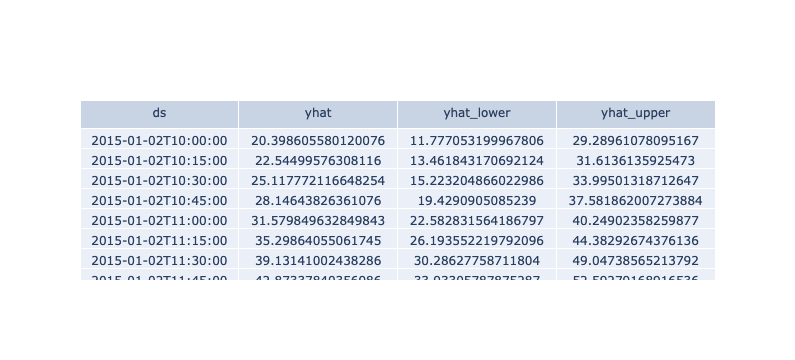

In [6]:
alpha=0.8
mdl_prophet_cli = Prophet(growth = 'linear',
                      interval_width=alpha,
                      #changepoint_prior_scale=0.0001,
                      #holidays_prior_scale=0.01,
                      #seasonality_prior_scale=0.0001,
                      #changepoint_range=0.4,
                      seasonality_mode="additive")

#mdl_prophet_cli.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
#mdl_prophet_cli.add_seasonality(name='daily', period=1, fourier_order=3, prior_scale=0.7)
mdl_prophet_cli.fit(df_cli_treino)

future_cli = mdl_prophet_cli.make_future_dataframe(periods=180, freq='15min')

future_cli['ds'] = pd.to_datetime(future_cli['ds'])
future_cli = future_cli.set_index(pd.DatetimeIndex(future_cli['ds']))
future_cli = future_cli.set_index(pd.DatetimeIndex(future_cli['ds']))
# Instead of adding 0 do this On the half-hourly predictions, due to the higher temporal resolution and in order to obtain better results some changes in the parameters ocurred. The changepoint_prior_scale is the regularizer of the effects that changepoints cause in the TS. Prophet assumes that the trend’s magnitude is modified at each changepoint. By leaving the default values for n_changepoint (parameter that specifies the number of changepoints), Prophet assumes a fixed value of 80% of historical data, which in the case study represents 839 changepoints in the training data set, setting the changepoint_prior_scale to a lower value, in each changepoint the trend may change in a smaller amount, therefore, less total change and less flexibility of the trend but concentrated in the same number of changepoints. on future dataframe
future_cli = future_cli.between_time('10:00','14:00')
forecast_cli = mdl_prophet_cli.predict(future_cli)
iplot(dtview.plot_forecast_as_table(forecast_cli))


### Viewing the hole TS

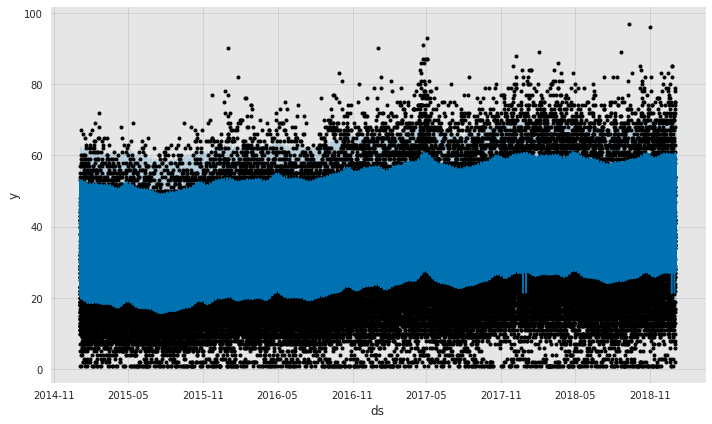

In [7]:

fig = mdl_prophet_cli.plot(forecast_cli)
plt.show()

### Checking TS components

#### Trend

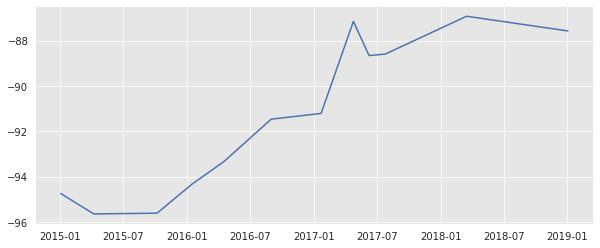

In [8]:
dtview.plot_trend(forecast_cli, mdl_prophet_cli)


# Sales analysis

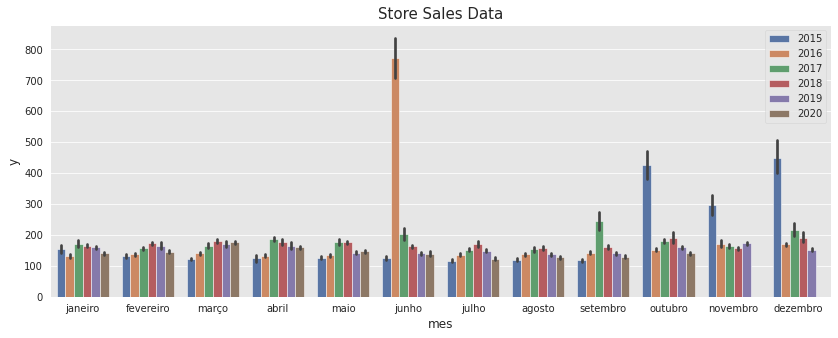

In [19]:
df_new=dtexp.extract_date_features(df_h_sales)
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="mes", y="y",hue = 'ano',data=df_new)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

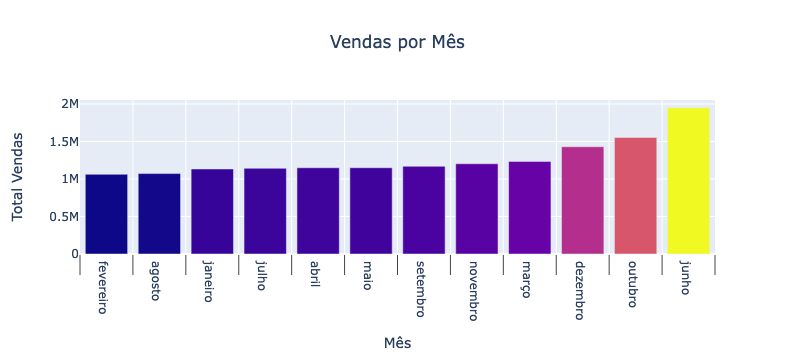

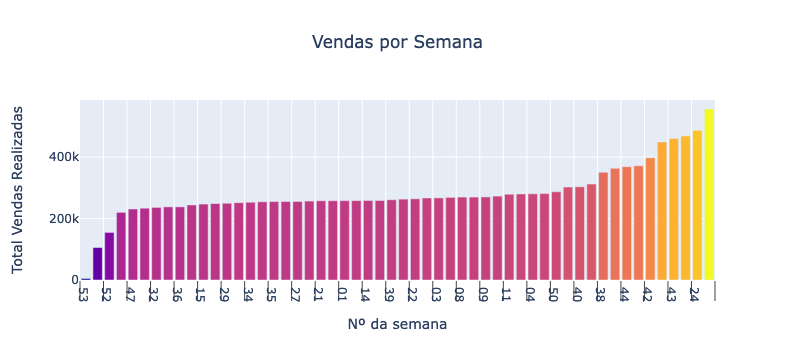

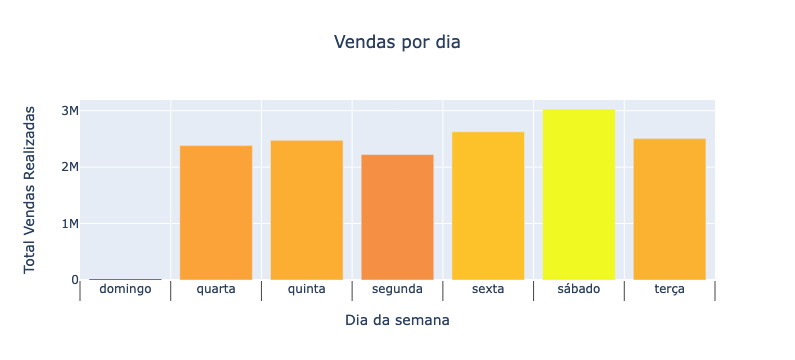

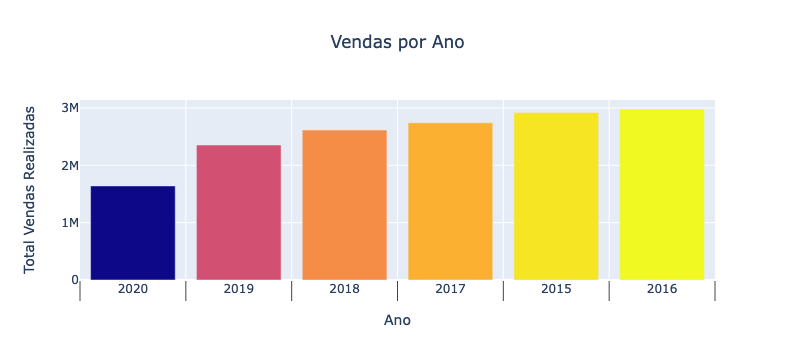

In [20]:
ano_agregado ,mes_agregado ,semana_agregado, dia_agregado = dtexp.analyze_dataframe(df_h_sales)

iplot(dtview.plot_dados_agregados_semana_mes(mes_agregado,tipo_agregacao='m',xaxes_title='Mês',yaxis_title='Total Vendas',
                                      title='Vendas por Mês'))
iplot(dtview.plot_dados_agregados_semana_mes(semana_agregado,tipo_agregacao='s',xaxes_title='Nº da semana',yaxis_title='Total Vendas Realizadas',
                                      title='Vendas por Semana'))

iplot(dtview.plot_dados_agregados_semana_mes(dia_agregado,tipo_agregacao='d',xaxes_title='Dia da semana',yaxis_title='Total Vendas Realizadas',
                                      title='Vendas por dia'))

iplot(dtview.plot_dados_agregados_semana_mes(ano_agregado,tipo_agregacao='a',xaxes_title='Ano',yaxis_title='Total Vendas Realizadas',
                                      title='Vendas por Ano'))


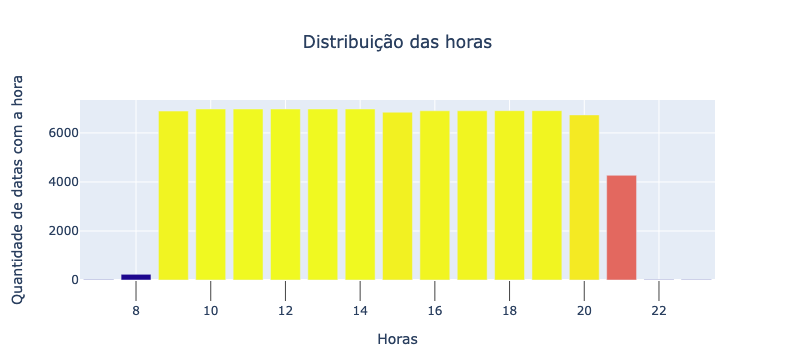

In [21]:
make_ds.save_processed_dataset(df_h_sales, filename='63_distribuicao_horas_por_dia.csv')
df_distrib_horas= make_ds.load_processed_dataset('63_distribuicao_horas_por_dia.csv')
df_distrib_horas.columns
hora=df_distrib_horas['ds'].tolist()
qtd_units=df_distrib_horas['ds.1'].tolist()
x_values=hora
y_values=qtd_units
title='Distribuição das horas'
xaxes_title='Horas'
yaxis_title='Quantidade de datas com a hora'
dtview.plot_results(x_values,y_values,title=title,xaxes_title=xaxes_title,yaxis_title=yaxis_title)

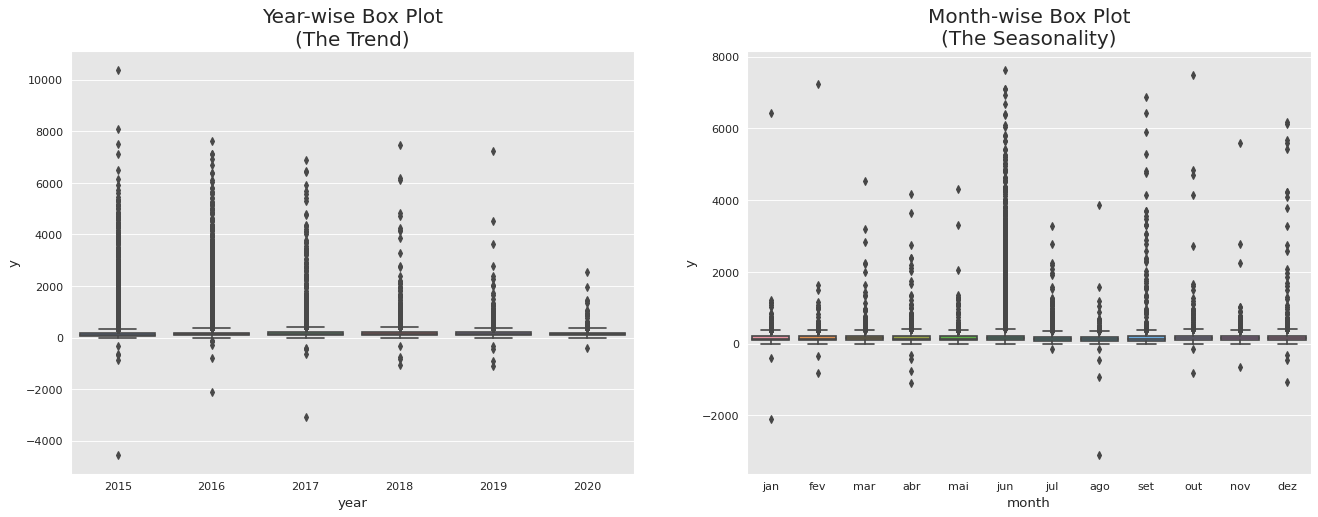

In [22]:
dtview.plot_bp_trend_seasonality(df_h_sales)


In [23]:
dtview.print_dataframe_core_info(df_h_sales)
print('Dataframe information: {}'.format(df_h_sales.info()))
df_h_sales.describe()

+-----------------------+---------------------+--------------------+
| Sales Dataframe Start | Sales Dataframe End | Data Period Range  |
+-----------------------+---------------------+--------------------+
|  2015-01-02 10:00:00  | 2020-10-17 21:15:00 | 2115 days 11:15:00 |
+-----------------------+---------------------+--------------------+
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87517 entries, 4063241 to 4150757
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   store      87517 non-null  int64         
 1   ds         87517 non-null  datetime64[ns]
 2   y          87517 non-null  int64         
 3   n_clients  87517 non-null  float64       
 4   year       87517 non-null  int64         
 5   month      87517 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.7+ MB
Dataframe information: None


store             y     n_clients          year
count  87517.0  87517.000000  87517.000000  87517.000000
mean      63.0    174.309300     29.869225   2017.396597
std        0.0    289.415496     15.382164      1.662388
min       63.0  -4542.000000      1.000000   2015.000000
25%       63.0     85.000000     18.000000   2016.000000
50%       63.0    136.000000     27.000000   2017.000000
75%       63.0    201.000000     40.000000   2019.000000
max       63.0  10372.000000     97.000000   2020.000000

# Split into train and test dataframe


# Finding dataframe data points (It is how prophet defines history_size)

In [19]:
threshold_date = pd.to_datetime('2018-12-31 14:00:00')
df_sales_treino, df_sales_teste = dtexp.split_dataframe(df_h_sales,threshold_date=threshold_date)
make_ds.get_history_data_points(df_sales_treino, data_percentage=0.8)-1


48594

In [ ]:
alpha=0.8
mdl_prophet = Prophet(growth = 'linear',
                      interval_width=alpha,
                      #changepoint_prior_scale=0.0001,
                      #holidays_prior_scale=0.01,
                      #seasonality_prior_scale=0.0001,
                      #changepoint_range=0.4,
                      seasonality_mode="additive")

#mdl_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
#mdl_prophet.add_seasonality(name='daily', period=1, fourier_order=3, prior_scale=0.7)
mdl_prophet.fit(df_sales_treino)

future_sales = mdl_prophet.make_future_dataframe(periods=180, freq='15min')

future_sales['ds'] = pd.to_datetime(future_sales['ds'])
future_sales = future_sales.set_index(pd.DatetimeIndex(future_sales['ds']))
future_sales = future_sales.set_index(pd.DatetimeIndex(future_sales['ds']))
# Instead of adding 0 do this On the half-hourly predictions, due to the higher temporal resolution and in order to obtain better results some changes in the parameters ocurred. The changepoint_prior_scale is the regularizer of the effects that changepoints cause in the TS. Prophet assumes that the trend’s magnitude is modified at each changepoint. By leaving the default values for n_changepoint (parameter that specifies the number of changepoints), Prophet assumes a fixed value of 80% of historical data, which in the case study represents 839 changepoints in the training data set, setting the changepoint_prior_scale to a lower value, in each changepoint the trend may change in a smaller amount, therefore, less total change and less flexibility of the trend but concentrated in the same number of changepoints. on future dataframe
future_sales = future_sales.between_time('10:00','14:00')
forecast_sales = mdl_prophet.predict(future_sales)
iplot(dtview.plot_forecast_as_table(forecast_sales))


### Viewing the hole TS

In [ ]:
forecast_sales = dtclean.remove_forecast_negative_values(forecast_sales)
fig = mdl_prophet.plot(forecast_sales)
plt.show()

### Checking TS components

#### Trend

In [ ]:
dtview.plot_trend(forecast_sales, mdl_prophet)

# Prophet Explained

## Trend - $g(t)$
Prophet uses regression to spot the trends on time series. It model non-periodic changes in time series using linear, logistic and flat growth. It can be modeled as piece-wise linear or saturating growth.

### Piece-wise linear growth

The fact that the time series model is basically a line that adds to the sum of periodic functions, allows it to be divided into pieces (parts) of the model and each piece (part) has its own parameters. This particularity offers an advantage for changes occurring during the time series that affect the trend and seasonality for a subset of the series data. Assuming that a data set changes at certain points in time, Prophets mathematical model defines the points in time for that subset of $ c_j $. In this context, it was necessary to adjust the trend to accommodate the points of change from one segment (part) of the model to another, thus, the trend is scaled to:

$$
g(t) = k + \sum_{j=1}^{c_j < t} \delta_j + m
$$


where $\delta_j$ is defined for each piece of the model. Prophets authors also highlight a matrix that is used to apply the model's parameter optimizations, therefore the function $g(t)$ is given by:
 $$
 g(t) = (k+a(t)^T\delta)t + (m + a(t)^T\gamma)
 $$

In the above equation, $k$ is the growth rate, $\delta$ is the rate adjustments, $\gamma$ is a set to make functions continuous and $m$ is the offset parameter.

Prophets uses stan as a backend to explore its statistics features and performance, acctually stan is Prophets statistic model itself. The piece-wise linear growth model is implemented in stan as function named  ``linear_trend`` and is given by:
``(k + A * delta) .* t + (m + A * (-t_change .* delta))``

- $k$ (Mx1 array): $M$ posterior samples of the initial slope.
- $A$: Matrix that serves to apply the optimizations of the model parameters.
- $t$ (Mx1 array): Times on which the function is evaluated.
- $t$_$change$ (Mx1 array): Points in time where changes occurred.
- $m$ (Mx1 array): Initial interception
- $delta$ (MxN array): Slope changes ate each of the $N$ changepoints.
- $beta$ (MXK matrix): Coefficients for K seasonality features.
- $sigma$_$obs$ (Mx1 array): Noise level

In [ ]:
trend=forecast_sales['trend']
#df['trend'] = np.power(df.index.values + 1, 2 / 5) + np.log(df.index.values + 3)

trend

In [ ]:
from src import prophet_stan_components as psc
import pystan
stan_model = psc.get_stan_model_code("""
parameters {
real k;
real m;
vector[S] delta;
real<lower=0> sigma_obs;
vector[K] beta;
}
model {
k ~ normal(0, 5);
m ~ normal(0, 5);
delta ~ double_exponential(0, tau);
sigma_obs ~ normal(0, 0.5);
beta ~ normal(0, sigmas);
y ~ normal(trend.* (1 + X * (beta .* s_m))+ X * (beta .* s_a),sigma_obs);
}
""")

schools_dat = {
    "J": 8,
    "y": [28, 8, -3, 7, -1, 1, 18, 12],
    "sigma": [15, 10, 16, 11, 9, 11, 10, 18],
}

sm = pystan.StanModel(model_code=schools_code, verbose=False)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)


stan_model.sampling(n_jobs=1).extract()['y']

In [ ]:
psc.get_prophet_setup_df(mdl_prophet, df_sales_treino)

## Seasonality

In [ ]:
dtview.plot_seasonality(mdl_prophet, 'weekly')

